In [1]:
import numpy as np
import random
import torchvision
from torchvision import transforms as transforms
from torch import nn
from torch.nn import functional as F
from math import cos
from math import pi
from torchsummary import summary

import os
import time
import torch
import math
import matplotlib.pyplot as plt



In [2]:
# set seeds 
torch.cuda.empty_cache()
torch.manual_seed(2221)
torch.cuda.manual_seed_all(2221)


In [3]:
# Apply normalization and HorizontalFlip to the data for augmentation transform

aug_train = transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])

aug_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
    ])


In [4]:
# load data

train_data = torchvision.datasets.CIFAR10('./CIFAR10',train=True,download=True,transform=aug_train)
test_data = torchvision.datasets.CIFAR10('./CIFAR10',train=False,download=True,transform=aug_test)
batch_size = 128
train_dataloader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data,batch_size=batch_size,shuffle=False)
train_size = len(train_dataloader)
test_size = len(test_dataloader)


100%|██████████| 170498071/170498071 [00:13<00:00, 12556322.34it/s]


Extracting ./CIFAR10/cifar-10-python.tar.gz to ./CIFAR10
Files already downloaded and verified


In [5]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_planes)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
       # self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        self.linear = nn.Linear(1024, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out
    




def decay_learning_rate(optimizer, current, max_epoch, min_rate, max_rate):
    # quicklly decrease the learning rate in the first 10 epoches
    if current < 10:
        lr = max_rate * current / 10
    # applying COSINEANNEALINGWARMRESTARTS in later epoches
    else:
        lr = min_rate + (max_rate-min_rate)*(1 + cos(pi * (current - 10) / (max_epoch - 10))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [6]:
# dispalying the model details   Total params: 3,154,762

model = ResNet(BasicBlock, [3,3,2]).cuda()
summary(model, input_size=(3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [7]:
epoch_num = 20
record = 'record_model.pt'

train_loss_history = []
test_loss_history = []
test_accuracy_history = []
train_accuracy_history = []

# used in dynamically learning rate adjustment
Loss = torch.nn.CrossEntropyLoss()
max_rate = 0.1 
min_rate=0.001

# train using different network
optimizer = torch.optim.SGD(model.parameters(),lr=max_rate,momentum=0.9,nesterov=True)
# optimizer = torch.optim.Adam(model.parameters(),lr=max_rate, betas=(0.9,0.999), eps=1e-08, amsgrad=True)

# load from the stored model
if os.path.exists(record):
  loaded_model = torch.load(record)
  model.load_state_dict(loaded_model['model_state_dict'])
  optimizer.load_state_dict(loaded_model['optimizer_state_dict'])
  Loss = loaded_model['Loss']
  train_loss_history = loaded_model['train_loss_history']
  test_loss_history = loaded_model['test_loss_history']
  test_accuracy_history = loaded_model['test_accuracy_history']
  train_accuracy_history = loaded_model['train_accuracy_history']

# otherwise, train the model from scratch     
else:
  for epoch in range(1, epoch_num + 1):
    train_loss = 0
    test_loss = 0
    train_accuracy = 0
    test_accuracy = 0
    for i, data in enumerate(train_dataloader):
      inputs = data[0].cuda()
      labels = data[1].cuda()
      total_num = len(labels)
      optimizer.zero_grad()
      predicted = model(inputs)
      max_prob = torch.max(predicted,1)[1]
      loss = Loss(predicted,labels)
      loss.backward()
      decay_learning_rate(optimizer,epoch,epoch_num,min_rate,max_rate)
      optimizer.step()
      train_loss += loss.item()
      epoc_acc = torch.eq(max_prob,labels).sum()/ total_num
      train_accuracy += (100* epoc_acc).data.cpu().numpy()

    for i, data in enumerate(test_dataloader):
      with torch.no_grad():
        inputs = data[0].cuda()
        labels = data[1].cuda()
        total_num = len(labels)
        optimizer.zero_grad()
        predicted = model(inputs)
        max_prob = torch.max(predicted,1)[1]
        loss = Loss(predicted,labels)
        test_loss += loss.item()
        epoc_acc = torch.eq(max_prob,labels).sum()/ total_num
        test_accuracy += (100* epoc_acc).data.cpu().numpy()

    train_loss = train_loss/train_size
    test_loss = test_loss/test_size
    train_accuracy = train_accuracy/train_size
    test_accuracy = test_accuracy/test_size

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)

    test_accuracy_history.append(test_accuracy)

    print('Epoch#{:3}, Train accuracy = {:.2f}%, Test accuracy =  {:.2f}%'.format(epoch,train_accuracy,test_accuracy))

    # store the current status 
    torch.save({'epoch':epoch,
            'model_state_dict':model.state_dict(),
            'optimizer_state_dict':optimizer.state_dict(),
            'Loss':Loss,
            'train_loss_history':train_loss_history,
            'test_loss_history':test_loss_history,
            'test_accuracy_history':test_accuracy_history,
            'train_accuracy_history':train_accuracy_history},record)
      


Epoch#  1, Train accuracy = 54.15%, Test accuracy =  66.97%
Epoch#  2, Train accuracy = 69.69%, Test accuracy =  77.11%
Epoch#  3, Train accuracy = 75.63%, Test accuracy =  79.11%
Epoch#  4, Train accuracy = 78.96%, Test accuracy =  82.80%
Epoch#  5, Train accuracy = 81.82%, Test accuracy =  83.31%
Epoch#  6, Train accuracy = 83.84%, Test accuracy =  84.22%
Epoch#  7, Train accuracy = 85.27%, Test accuracy =  86.44%
Epoch#  8, Train accuracy = 86.39%, Test accuracy =  86.41%
Epoch#  9, Train accuracy = 87.40%, Test accuracy =  87.31%
Epoch# 10, Train accuracy = 88.52%, Test accuracy =  87.97%
Epoch# 11, Train accuracy = 89.81%, Test accuracy =  88.73%
Epoch# 12, Train accuracy = 91.24%, Test accuracy =  89.29%
Epoch# 13, Train accuracy = 92.29%, Test accuracy =  89.05%
Epoch# 14, Train accuracy = 93.57%, Test accuracy =  90.86%
Epoch# 15, Train accuracy = 94.81%, Test accuracy =  91.12%
Epoch# 16, Train accuracy = 95.95%, Test accuracy =  91.74%
Epoch# 17, Train accuracy = 96.94%, Test

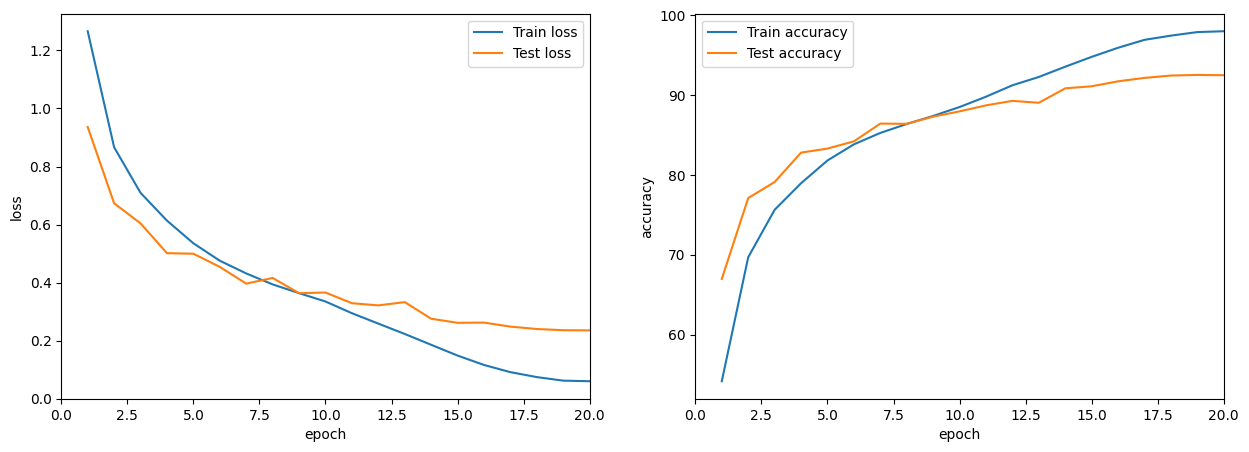

In [8]:
# plot the loss and accuracy curve of differnt models

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(range(1,epoch_num+1),train_loss_history,label='Train loss')
plt.plot(range(1,epoch_num+1),test_loss_history,label='Test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.xlim([0, epoch_num])
plt.legend()


plt.subplot(1,2,2)
plt.plot(range(1,epoch_num+1),train_accuracy_history,label='Train accuracy')
plt.plot(range(1,epoch_num+1),test_accuracy_history,label='Test accuracy')
plt.xlim([0, epoch_num])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()




In [9]:
print('Accuracy =', "{:.2f}%".format(max(test_accuracy_history)))

Accuracy = 92.54%
